# <u> Used Car Price Predictor - Dan Churchill - Sep 29, 2022

In [1]:
# data cleaning, testing, and visualizations
import wrangle
import explore

# visualizing data
import seaborn as sns
import matplotlib.pyplot as plt
from skimpy import skim

# tabular data and linear algebra
import pandas as pd
import numpy as np

# modeling and evaluation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from category_encoders import TargetEncoder
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from scipy import stats


# presentation settings
import warnings
warnings.filterwarnings('ignore')
plt.rc('figure', figsize=(18, 9))
plt.style.use('seaborn-white')
plt.rc('font', size=16)

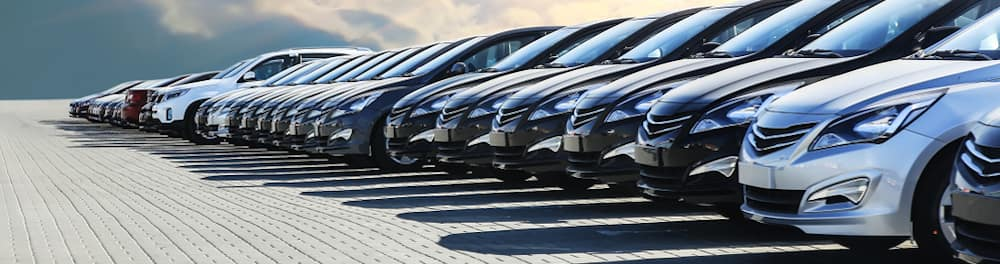

# <u>Project Overview and Goals</u>

<div class="alert alert-block alert-success">
<b><font size="+1">The purpose of this project is utilize a database of used auto sales to construct a model that can predict sale price.  The database includes the Manheim Market Report price, an industry standard for pricing automobiles.  Can that model be beaten?
<br><br>
    
    
Goal 1: Build a model using only the features of the vehicle to predict sales price.<br>
<br>
    Goal 2:  Build a model using the MMR estimate along with the auto's features to improve upon the MMR model.<br><br>
    Goal 3:  Try some tools I haven't previously used including Skim, Pipeline, TargetEncoder, and XGBoost.

# <u>Data Acquisition</u>

In [2]:
# read the data from a local csv originally obtained from:
#    https://www.kaggle.com/code/desalegngeb/auctioning-used-cars-what-matters-most/data?select=car_prices.csv

df = pd.read_csv('car_prices.csv', error_bad_lines=False, warn_bad_lines=False)

### Initial look at my data using skim

In [3]:
# skimpy is a 'supercharged describe' that provides summary data for dataframes
# while it has some limitations, it is a convenient way to get a quick look at a dataset
#     Details at:   https://pypi.org/project/skimpy/
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 558811 │ │ string      │ 11    │                                                          │
│ │ Number of columns │ 16     │ │ int64       │ 3     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 2     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name      ┃ NA      ┃ NA %    ┃ mean    ┃ sd      ┃ p0     ┃ p25     ┃ p75     ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ year             │       0 │       0 │    2000 │       4 │   2000 │    2000 │    2000 │      2000 │    ▁▃█ │  │
│ │ condition        │   12000 │     2.1 │     3.4 │    0.95 │      1 │     2.7 │     4.2 │         5 │  ▄▅▆█▅ │  │
│ │ odometer         │      94 │   0.017 │   68000 │   53000 │      1 │   28000 │   99000 │   1000000 │   █    │  │
│ │ mmr              │       0 │       0 │   14000 │    9700 │     25 │    7100 │   18000 │    180000 │   █    │  │
│ │ sellingprice     │       0 │       0 │   14000 │    9700 │      1 │    6900 │   18000 │    230000 │   █    │  │
│ └──────────────────┴─────────┴─────────┴─────────┴─────────┴────────┴─────────┴─────────┴───────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA           ┃ NA %       ┃ words per row              ┃ total words           ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ make                      │        10000 │        1.8 │                       0.98 │                550000 │  │
│ │ model                     │        10000 │        1.9 │                       0.98 │                550000 │  │
│ │ trim                      │        11000 │        1.9 │                       0.98 │                550000 │  │
│ │ body                      │        13000 │        2.4 │                       0.98 │                550000 │  │
│ │ transmission              │        65000 │         12 │                       0.98 │                550000 │  │
│ │ vin                       │            0 │          0 │                       0.98 │                550000 │  │
│ │ state                     │            0 │          0 │                       0.98 │                550000 │  │
│ │ color                     │          750 │       0.13 │                       0.98 │                550000 │  │
│ │ interior                  │          750 │       0.13 │                       0.98 │                550000 │  │
│ │ seller                    │            0 │          0 │                       0.98 │                550000 │  │
│ │ saledate                  │            0 │          0 │                       0.98 │                550000 │  │
│ └───────────────────────────┴──────────────┴──────────

With over 558K rows there should be plenty of data to explore.  
Most of the null values (12% of the dataframe) is in the transmission column

In [4]:
# look at values for transmission
df.transmission.value_counts()

automatic    475914
manual        17544
Name: transmission, dtype: Int64

- We can convert nulls in transmission to 'unknown', in order to explore further later.

- After exploring the remaining columns with nulls there doesn't appear to be any significance.  
- I'll drop the rows rather than imputing values since they don't make up a significant chunk of the dataset.

In [5]:
# look at values of 'make'
df.make.value_counts()

Ford          93554
Chevrolet     60197
Nissan        53946
Toyota        39871
Dodge         30710
              ...  
airstream         1
ford tk           1
chev truck        1
hyundai tk        1
Lotus             1
Name: make, Length: 96, dtype: Int64

#### 'Ford' vs 'ford' vs 'ford tk' 

        - Will need to filter and convert using string manipulation
        - Several makes with low number of observations (Lotus, Delorian, etc.) that will be filtered out
            - Similiar operations performed on State, Color, Interior, etc to be handled in the same way

In [6]:
# look at values for 'vin'
df.vin.value_counts()

wbanv13588cz57827    5
wp0ca2988xu629622    4
5n1ar1nn2bc632869    4
wddgf56x78f009940    4
trusc28n241022003    4
                    ..
5gtdn136968177965    1
1lnhm82v36y610348    1
wmwre33546tj33043    1
salae254x6a381803    1
1ftfw1et2eke87277    1
Name: vin, Length: 550296, dtype: Int64

- VIN should be a unique value, so repeat VINs could indicate multiple sales or mis-entry.  
- Since this occurs less than 1% of the time, I will drop all instances where duplicates occur

In [7]:
# look at values for 'color'
df.color.value_counts().head(9)

black     110970
white     106673
silver     83389
gray       82857
blue       51139
red        43569
—          24685
green      11382
gold       11342
Name: color, dtype: Int64

- Color and interior had columns with dashes.  Convert these to 'unknown'

In [8]:
# look at selling price
print('Range of Selling Price is: ',end='')
print("${:.2f}".format(df.sellingprice.min()),end=' - ')
print("${:.2f}".format(df.sellingprice.max()))

Range of Selling Price is: $1.00 - $230000.00


I don't want salvage sales or exotics, but we do want a wide range, so I'll filter the outliers that are more than 3 std deviations from the interquartile range

In [9]:
# perform cleanup as addressed above using a custom 'carwash' function, then take another look at our data
df = wrangle.carwash_1(df)
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 513951 │ │ string      │ 11    │                                                          │
│ │ Number of columns │ 16     │ │ int64       │ 4     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name       ┃ NA   ┃ NA %   ┃ mean     ┃ sd      ┃ p0     ┃ p25     ┃ p75     ┃ p100       ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━┩  │
│ │ year              │    0 │      0 │     2000 │     3.8 │   2000 │    2000 │    2000 │       2000 │   ▁▂▂█  │  │
│ │ condition         │    0 │      0 │      3.4 │    0.95 │      1 │     2.7 │     4.2 │          5 │  ▄▄▅█▅  │  │
│ │ odometer          │    0 │      0 │    66000 │   52000 │      1 │   28000 │   96000 │    1000000 │    █    │  │
│ │ mmr               │    0 │      0 │    14000 │    8700 │     25 │    7500 │   18000 │     110000 │   █▂    │  │
│ │ sellingprice      │    0 │      0 │    14000 │    8800 │      1 │    7300 │   18000 │      52000 │  ▆█▄▁   │  │
│ └───────────────────┴──────┴────────┴──────────┴─────────┴────────┴─────────┴─────────┴────────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                ┃ NA     ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ make                       │      0 │          0 │                            1 │                   520000 │  │
│ │ model                      │      0 │          0 │                            1 │                   520000 │  │
│ │ trim                       │      0 │          0 │                            1 │                   520000 │  │
│ │ body                       │      0 │          0 │                            1 │                   520000 │  │
│ │ transmission               │      0 │          0 │                            1 │                   520000 │  │
│ │ vin                        │      0 │          0 │                            1 │                   520000 │  │
│ │ state                      │      0 │          0 │                            1 │                   520000 │  │
│ │ color                      │      0 │          0 │                            1 │                   520000 │  │
│ │ interior                   │      0 │          0 │                            1 │                   520000 │  │
│ │ seller                     │      0 │          0 │                            1 │                   520000 │  │
│ │ saledate                   │      0 │          0 │                            1 │                   520000 │  │
│ └────────────────────────────┴────────┴────────────┴──

### Prepare takeaways

<div class="alert alert-block alert-info">
<b><font size="+1">The initial acquisition and cleaning of data left 513K clean and unique observations by performing the following cleanup: 
<br><br>
    - Converted nulls in transmission category to 'unknown', remaining nulls were dropped<br>
    - Used string manipulation to standardize values in the make, model, trim, color, interior, and state categories<br>
    - Filtered extreme outliers from our target variable, sellingprice<br>
    - Utilized a new tool, skimpy, to get a broad overview of the data

# <u>Data Exploration</u>

### What are the characteristics of the target variable, sellingprice?

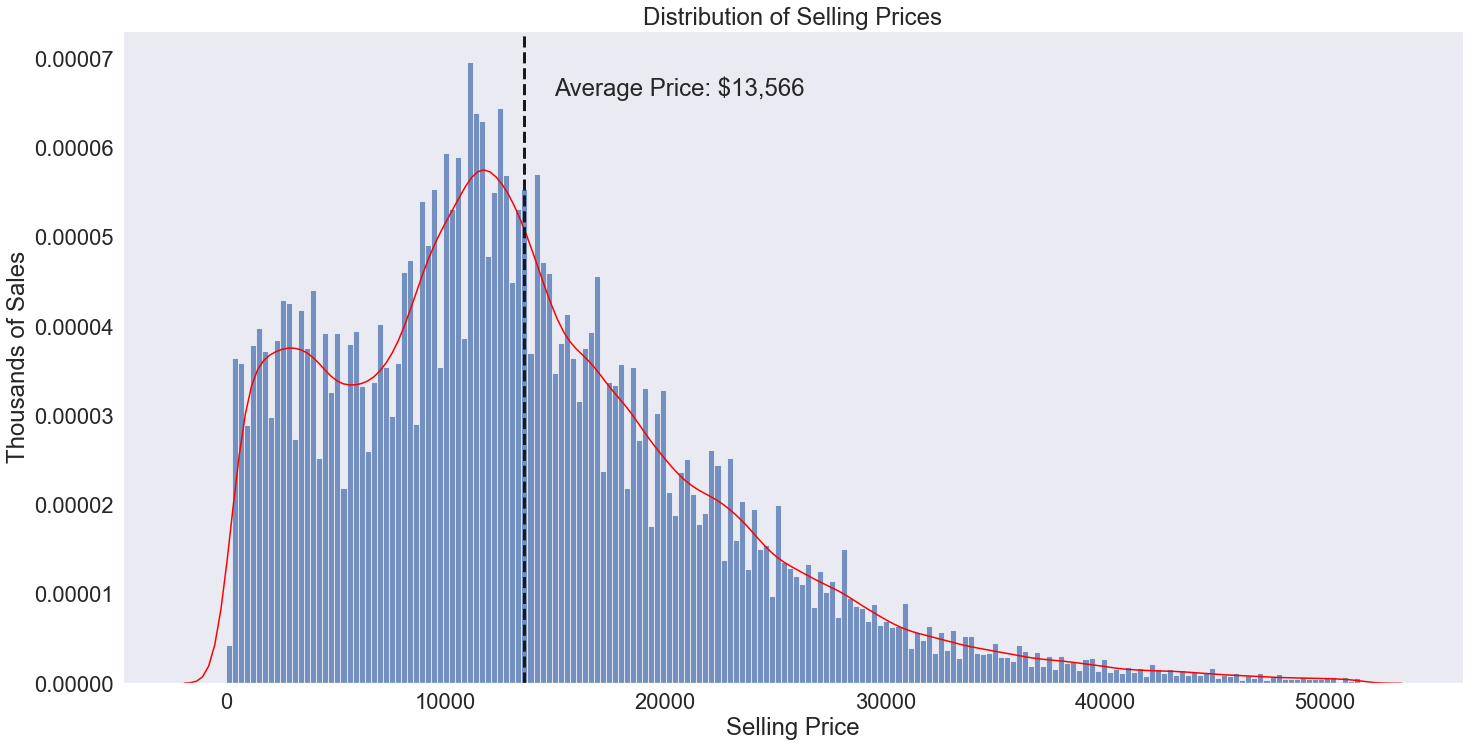

In [10]:
# plot the distribution using a custom function
explore.plot_dist(df)

#### Distribution is somewhat normal, but right skewed.

### Split data into 60% train, 20% validate, and 20% test

In [11]:
# data is split using custom function
train, validate, test = wrangle.split_cars(df)

## How good is MMR at predicting sales price? 

The Manheim Market Report (MMR) is a valuation guide that provides prices for used automobiles.  

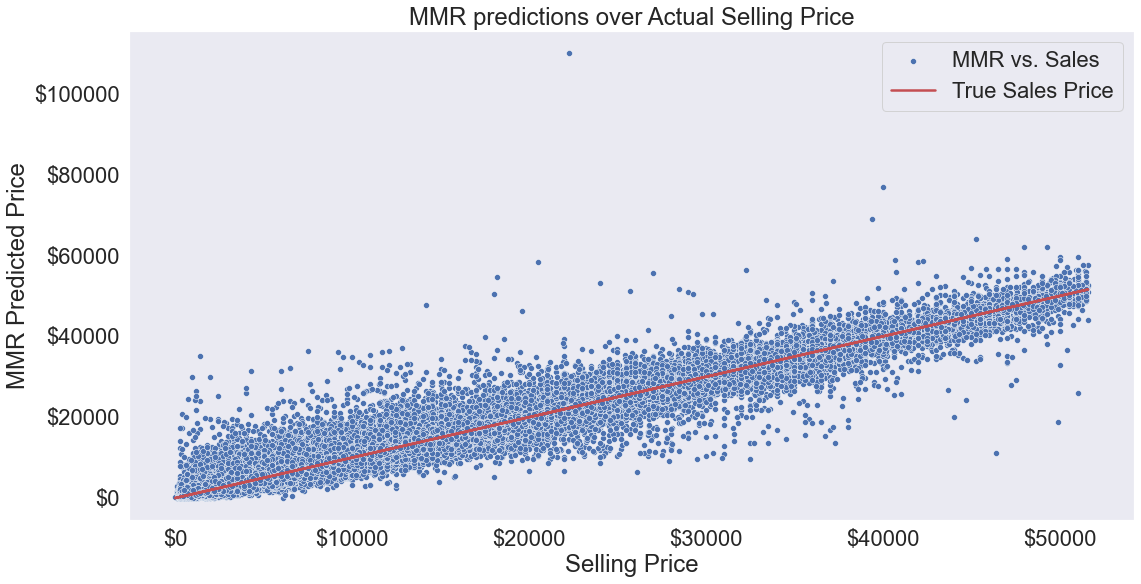

In [12]:
# Plot MMR valuation vs Actual Selling Price
explore.mmr_plot(train)

### Does MMR predict sales price better than the Mean prediction?

In [13]:
# Determine Error of MMR's model
rmse_mmr = round(mean_squared_error(train.sellingprice, train.mmr, squared=False),2)
r2_mmr = round(r2_score(train.sellingprice, train.mmr),4)
print(f'MMR Baseline RMSE: ${rmse_mmr}, MMR Baseline R2: {r2_mmr}')

MMR Baseline RMSE: $1669.92, MMR Baseline R2: 0.9636


In [14]:
# Determine Baseline 
train['baseline'] = train.sellingprice.mean()
rmse_baseline = round(mean_squared_error(train.sellingprice, train.baseline, squared=False),2)
r2_baseline = round(r2_score(train.sellingprice, train.baseline))
print(f'Mean Baseline RMSE: ${rmse_baseline}, Mean Baseline R2: {r2_baseline}')
train.drop(columns=['baseline'],inplace=True)

Mean Baseline RMSE: $8757.62, Mean Baseline R2: 0


#### MMR does a pretty good job predicting sales price, far exceeding the mean prediction and yielding an R2 score of 96%

## How does transmission affect selling price?

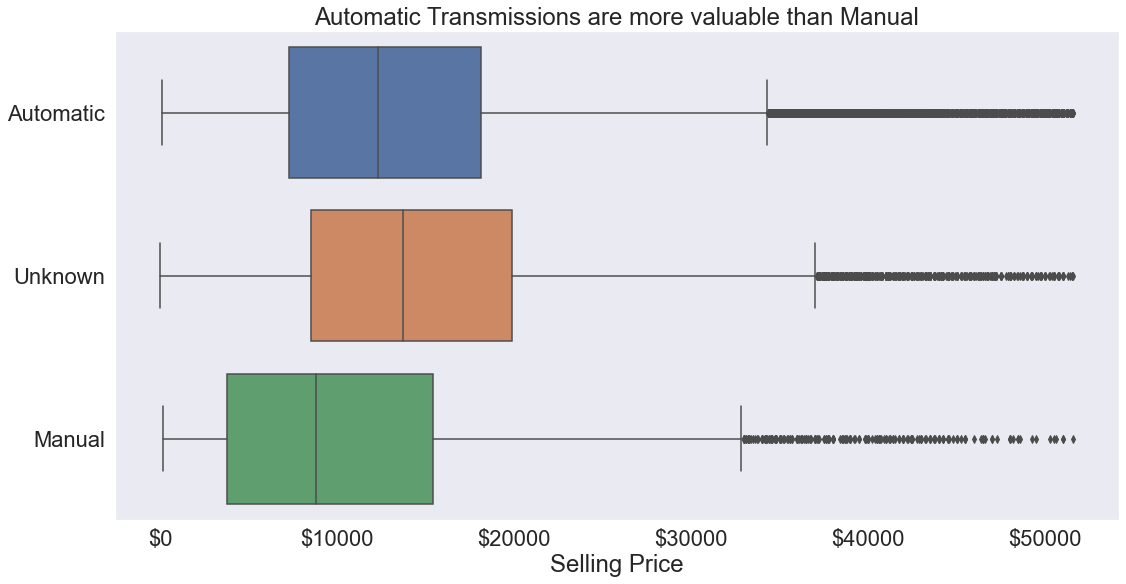

In [15]:
# plot and test using a modular function
explore.transmission_plot(train)

- **Hypothesis**

- $H_0$: There is no difference in selling price between the different transmission types

- $H_a$: There is a significant difference in selling price between the different transmission types

In [16]:
# Perform  ANOVA test function from explore.py
explore.transmission_anova(train)

Selling price of automatics:            $13498.51
Selling price of unknown transmissions: $14784.85
Selling price of manuals:               $10831.89

We reject the Null Hypothesis, there is a significant difference in selling price between the different transmission types 


## What makes are the most and least valuable?

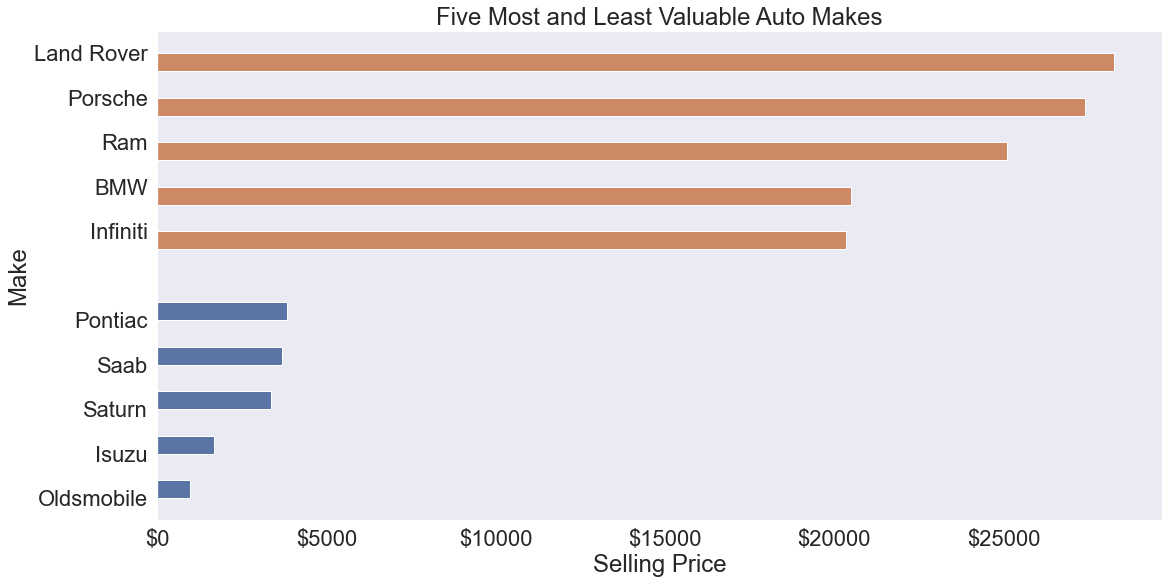

In [17]:
# find top and bottom 5 makes and plot using modular function
explore.make_plot(train)

In [18]:
# Get the number of unique makes
train.make.nunique()

41

#### With 41 makes and a large variance in values, we will utilize TargetEncoding rather than One-Hot or Label Encoding

## Are Year and Odometer correlated, and if so how do they effect selling price?

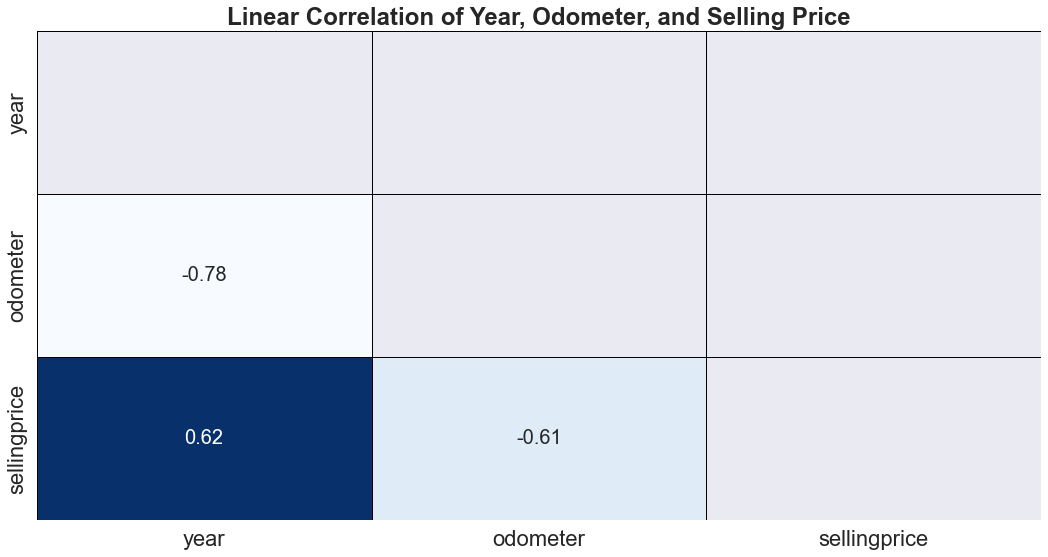

In [19]:
# plot a correlation heatmap using modular function
explore.heatmap(train)

#### Odometer and Year show fairly strong negative linear correlation to Selling Price, but they also appear correlated to each other

In [20]:
# perform Analysis of Variance Assessment and display results
explore.correlation_test(train, 'odometer', 'year')

H0: odometer is not linearly correlated to year
Ha: odometer is linearly correlated to year

Correlation coefficient is: -0.778
H0 is rejected, odometer is negatively correlated to year


#### I don't want the correlated values of year and odometer, but I still want to capture the unique values
    - Convert year to age to capture the effect of older vehicles
    - Divide Odometer by age to place a value on relative wear on the vehicle

In [21]:
# create the features discussed above, and drop columns not needed for modeling
train = wrangle.carwash_2(train)
validate = wrangle.carwash_2(validate)
test = wrangle.carwash_2(test)

In [22]:
train.head(1)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice,age_at_sale,miles_per_year
387777,2010,Chevrolet,Silverado 2500HD,LTZ,truck,automatic,FL,3.8,126386,white,black,18800,20600,5,25277


In [23]:
# perform pearson r test using modular function
explore.correlation_test(train, 'miles_per_year', 'age_at_sale')

H0: miles_per_year is not linearly correlated to age_at_sale
Ha: miles_per_year is linearly correlated to age_at_sale

Correlation coefficient is: -0.291
H0 is rejected, miles_per_year is negatively correlated to age_at_sale


#### The New features Age, and Miles per Year are still slightly correlated, but much less than year and odometer

## Is condition a driver of selling price?

#### Condition is a 1.0 to 5.0 rating on the relative condition of the vehicle

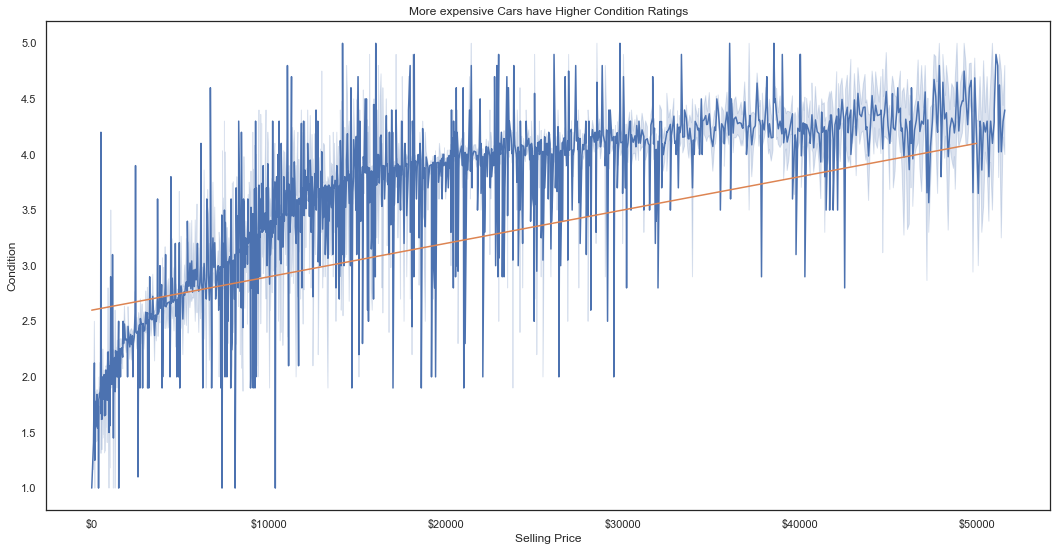

In [24]:
# plot condition vs Selling price using modular function
explore.condition_plot(train)

In [25]:
# perform pearsons r test using modular function
explore.correlation_test(train, 'condition', 'sellingprice')

H0: condition is not linearly correlated to sellingprice
Ha: condition is linearly correlated to sellingprice

Correlation coefficient is: 0.563
H0 is rejected, condition is positively correlated to sellingprice


## Explore takeaways

<div class="alert alert-block alert-info">
<b><font size="+1">After univariate, multivariate, and visual exploration of the data I found the following: 
<br><br>
    - Distribution of the target variable, selling price, is a right-skewed normal distribution<br>
    - MMR is an excellent predictor of sales price.  We'll try to beat it, then improve upon it<br>
    - Transmission, condition, make, model, color, and interior all drive the price, and we'll target-encode<br>
    - Odometer and year are co-linear.  Converted to age_at_sale and miles_per_year to reduce colinearity

# <u>Modelling</u>

Categorical variables will be encoded using TargetScaler, which scales the variable by assigning the mean of the target variable

In [26]:
# encode categorical variables by scaling based upon the mean of the target variable
cats=['trim', 'body', 'make', 'transmission', 'state', 'model', 'color', 'interior']
te = TargetEncoder()
t_values = te.fit_transform(X = train[cats], y = train.sellingprice).add_prefix('enc_')
train = pd.concat([train, t_values], axis = 1)

v_values = te.transform(X = validate[cats], y = validate.sellingprice).add_prefix('enc_')
validate = pd.concat([validate, v_values], axis = 1)

test_values = te.transform(X = test[cats], y = test.sellingprice).add_prefix('enc_')
test = pd.concat([test, test_values], axis = 1)

Verify that columns were transformed as intended

In [27]:
# view last 8 columns to see the effects of Target Encoding
train.iloc[: , -8:].head()

,enc_trim,enc_body,enc_make,enc_transmission,enc_state,enc_model,enc_color,enc_interior
387777,18280.555365,17877.614392,11842.323094,13500.149670,13711.878810,20866.449935,14692.905449,15414.081126
444467,30197.990544,15962.564295,28266.643836,14786.343246,15699.569014,26784.209040,15239.380078,15414.081126
147254,11974.069468,11876.962688,11792.225251,13500.149670,15210.565574,11466.132518,14692.905449,15414.081126
20387,9946.176094,17877.614392,14605.312481,14786.343246,13445.988668,7926.469466,13883.011674,11177.726947
498221,9385.785775,11876.962688,11084.366723,13500.149670,13711.878810,7668.734868,11526.116106,13143.021305


In [28]:
# drop original columns
train.drop(columns=cats, inplace=True)
validate.drop(columns=cats, inplace=True)
test.drop(columns=cats, inplace=True)

## Predicting Selling Price without MMR
#### Can we beat $1670?

In [29]:
# create X and y
X_train = train.drop(columns = ['sellingprice','mmr','year'])
X_val = validate.drop(columns= ['sellingprice','mmr','year'])

y_train = train.sellingprice
y_val = validate.sellingprice

sklearn's Pipeline lets me package a scaler and model into one object, making it easier to work with

### SK Learn's LinearRegression

In [30]:
# build pipeline
pipeline1 = Pipeline([('scaler', MinMaxScaler()), ('model', LinearRegression())])
# fit pipeline (scaler and model)
pipeline1.fit(X_train, y_train)

# predict and evaluate using custom function
explore.pred_eval(pipeline1, X_train, y_train, X_val, y_val)

In-sample RMSE: 3985.74, In-sample r2: 0.793
Out-of-sample RMSE: 3984.32, Out-of-sample r2: 0.795


### XGBoost's XGBRegressor

In [31]:
# build XGB pipeline
pipeline2 = Pipeline([('scaler', MinMaxScaler()), ('model', xgb.XGBRegressor(eta=.05,
                                                                           gamma=0,
                                                                           min_child_weight=3,
                                                                           max_leaves=7,
                                                                           max_depth=4))])
# fit pipeline (scaler and model)
pipeline2.fit(X_train, y_train)

# predict and evaluate using custom function
explore.pred_eval(pipeline2, X_train, y_train, X_val, y_val)

In-sample RMSE: 3002.07, In-sample r2: 0.882
Out-of-sample RMSE: 3013.21, Out-of-sample r2: 0.883


## My best model beat the Mean Baseline by a significant margin, but failed to beat the MMR predictions. Can my model improve upon MMR by including it as a feature?


In [32]:
# recreate X, this time including MMR as a feature
X_train = train.drop(columns = ['sellingprice','year'])
X_val = validate.drop(columns= ['sellingprice','year'])

### SK Learn's LinearRegression

In [33]:
# build pipeline
pipeline3 = Pipeline([('scaler', MinMaxScaler()), ('model', LinearRegression())])
# fit pipeline (scaler and model)
pipeline3.fit(X_train, y_train)

# predict and evaluate using custom function
explore.pred_eval(pipeline3, X_train, y_train, X_val, y_val)

In-sample RMSE: 1480.57, In-sample r2: 0.971
Out-of-sample RMSE: 1513.22, Out-of-sample r2: 0.97


#### I improved upon MMR by more than $150 on the validation set!

### XGBoost's XGBRegressor

In [34]:
# build XGB pipeline
pipeline4 = Pipeline([('scaler', MinMaxScaler()), ('model', xgb.XGBRegressor(eta=.05,
                                                                           gamma=0,
                                                                           min_child_weight=3,
                                                                           max_leaves=7,
                                                                           max_depth=4))])
# fit pipeline (scaler and model)
pipeline4.fit(X_train, y_train)

# predict and evaluate using custom function
explore.pred_eval(pipeline4, X_train, y_train, X_val, y_val)

In-sample RMSE: 1404.09, In-sample r2: 0.974
Out-of-sample RMSE: 1442.26, Out-of-sample r2: 0.973


#### This model improved upon MMR by over $230 on the validate set

## Confirming performance of our best model on the test dataset

Test RMSE: 1406.52, Test r2: 0.974


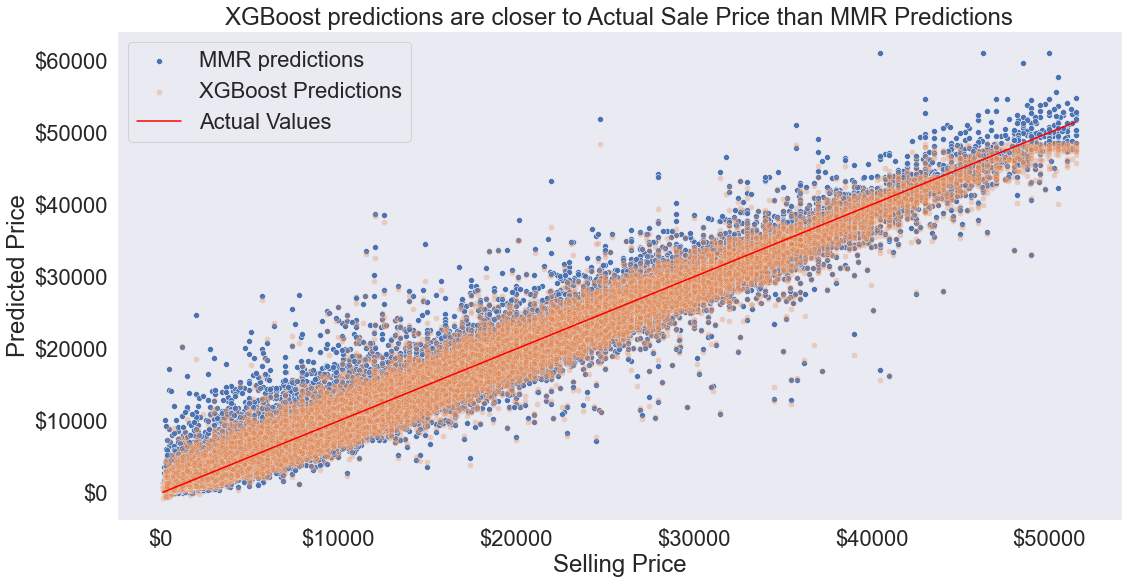

In [35]:
# create X and y for the test data
X_test = test.drop(columns= ['sellingprice','year'])
y_test = test.sellingprice

# test and evaluate
explore.test_eval(pipeline4, test)

## Modeling Takeaways

<div class="alert alert-block alert-info">
<b><font size="+1">I was not able to create an independent model that bettered the MMR model, but I was able to utilize the MMR value to create a model that improved upon MMR by $264 on the test dataset.  
<br><br>
    The visualization shows that the model was able to make predictions closer to the line of actual predictions, especially where MMR overvalues vehicles, and the outliers were less dramatic
    
XGBoost was more effective than SKlearn's LinearRegression, and utilizing Pipeline was a clean way to create and fit scaler and modelling objects.  

# <u>Conclusion</u>

<div class="alert alert-block alert-success">
<b><font size="+1"><u>Summary</u><br>
The purpose of this project was utilize a database of used auto sales to construct a model that can predict sale price.  
    
- The first goal, to build a stand-alone model that beat the Manheim Market Report estimate, failed.<br><br>
- I was successfull at my second goal, to utilize the MMR estimate to improve upon their model.<br><br>
- I was able to utilize Skim, Pipeline, TargetEncoder, and XGBoost in my project, all of which simplified and improved my process and final product.
<br><br>

<u>Drivers of Selling Price</u><br>
Through initial testing of multiple models I was able to determine that the key drivers of a car's price were the make, age, model, and transmission type.  

<u>Expecations for Implementation</u><br>
The consistant and outstanding performance on the test data indicates performance on new/unseen data would be high.
    
<u>Recommendations</u><br>
I recommend implemation of this model for business use at this time only if a stream of recent and reliable sales data can be obtained in order to keep the model current.  Most of the sales in this dataset were from 2014-2015, so updated data to re-train the model would be required before using it to make purchase decisions.
    
<u>Next Steps</u><br>
With more time I would further tune the hyperparameters of the XGBoost model to try and obtain even better performance.  Additionally, the VIN could be used to obtain more features about the vehicle such as engine size or technology packages.  These could further improve model performance, but given that the current performance is more than adequate it may not be a wise investment of resources for what would likely be an incremental improvement.